# Quantization Troubleshooting with XQuant

[Run this tutorial in Google Colab](https://colab.research.google.com/github/sony/model_optimization/blob/main/tutorials/notebooks/mct_features_notebooks/keras/example_keras_xquant.ipynb)

This notebook demonstrates the process of generating an xquant report. The report provides valuable insights such as histograms and the similarity metrics between the original float model and the quantized model, which can be visualized using TensorBoard.

## Steps:
1. Load a pre-trained MobileNetV2 model and perform post-training quantization.
5. Define an xquant configuration.
6. Generate an xquant report to compare the float and quantized models.
7. Visualize the report using TensorBoard.

## Install

In [1]:
!git clone https://github.com/reuvenperetz/model_optimization.git
!cd model_optimization && git checkout xquant
!pip install -r model_optimization/requirements.txt
!pip install tensorflow

Cloning into 'model_optimization'...
remote: Enumerating objects: 26421, done.
remote: Counting objects: 100% (6245/6245), done.
remote: Compressing objects: 100% (1409/1409), done.
remote: Total 26421 (delta 5508), reused 5008 (delta 4835), pack-reused 20176
Receiving objects: 100% (26421/26421), 13.31 MiB | 12.23 MiB/s, done.
Resolving deltas: 100% (20296/20296), done.
Branch 'xquant' set up to track remote branch 'xquant' from 'origin'.
Switched to a new branch 'xquant'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 kB 6.8 MB/s eta 0:00:00


## Import necessary libraries

In [ ]:
import sys
sys.path.append('/content/model_optimization')
import model_compression_toolkit as mct
import numpy as np
from functools import partial
from model_compression_toolkit.xquant import XQuantConfig
import tensorflow as tf

## Define data generator
For demonstration only, we will use a random dataset generator for the representative dataset and for the validation dataset:

In [ ]:
# Function to generate random data. If use_labels is True, it yields data with labels;
# otherwise, it yields only data.
def random_data_gen(shape=(224, 224, 3), use_labels=False, batch_size=2, num_iter=1):
    if use_labels:
        for _ in range(num_iter):
            yield [[np.random.randn(batch_size, *shape)], np.random.randn(batch_size)]
    else:
        for _ in range(num_iter):
            yield [np.random.randn(batch_size, *shape)]

## Quantize MobileNetV2

We will start by quantizing MobilNetV2 using `keras_post_training_quantization`:

In [ ]:
# Load the pre-trained MobileNetV2 model and perform post-training quantization using
# the representative dataset generated by random_data_gen.
from keras.applications.mobilenet_v2 import MobileNetV2
float_model = MobileNetV2()
repr_dataset = random_data_gen
quantized_model, _ = mct.ptq.keras_post_training_quantization(in_model=float_model,
                                                              representative_data_gen=repr_dataset)

## Generate report

We will use the `./logs` directory for saving the generated logs. In addition, we will add a similarity metric to measure in addition to the default similarity metrics that are being computed (currently, MSE, CS and SQNR):

In [ ]:
# Define the validation dataset and xquant configuration, including custom similarity metrics.
validation_dataset = partial(random_data_gen, use_labels=True)
xquant_config = XQuantConfig(report_dir='./logs', custom_similarity_metrics={'mae': lambda x, y: float(tf.keras.losses.MAE(x.flatten(), y.flatten()).numpy())})

# Generate the xquant report comparing the float model and the quantized model using the
# representative and validation datasets.
from model_compression_toolkit.xquant import xquant_report_keras_experimental
result = xquant_report_keras_experimental(
            float_model,
            quantized_model,
            repr_dataset,
            validation_dataset,
            xquant_config
        )

## Visualize in Tensorboard

In the tensorboard, one can find useful information like statistics of the float layers' outputs and the graph of the quantized model with similarities that were measured comparing to the float model. Currently, the similarity is measured at linear layers like Conv2D, Dense, etc. (may be changed in the future). When observing such node in the graph, the similarities can be found in the node's properties as 'xquant_repr' and 'xquant_val'.
Make sure to choose 'xquant' from the 'Run' dropdown menu on the left side of TensorBoard.

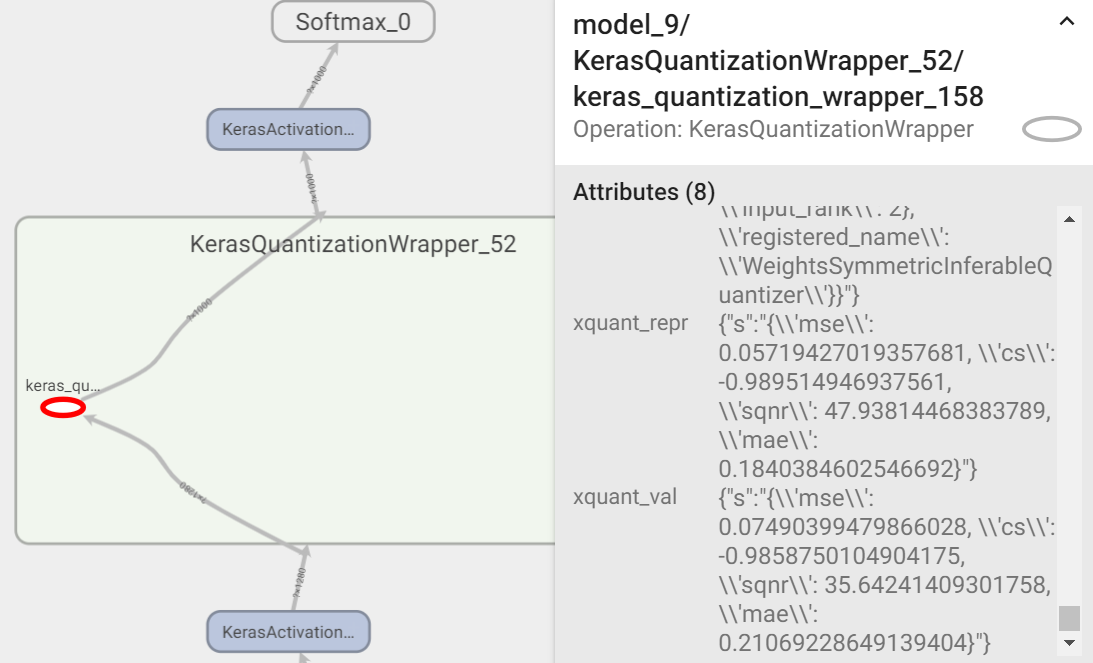

Now we can run tensorboard:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs